In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import pandas as pd
import numpy as np
import pickle
from PIL import Image
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

In [5]:
df = pd.read_csv('M:\DL projects\cr1\data\creditcard.csv')

In [27]:
df.shape

(284807, 30)

In [28]:
df.isnull().values.any()

False

C:\Users\ASUS\AppData\Local\Temp\ipykernel_436\1754543922.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Class'], sort = True)


NameError: name 'Num' is not defined

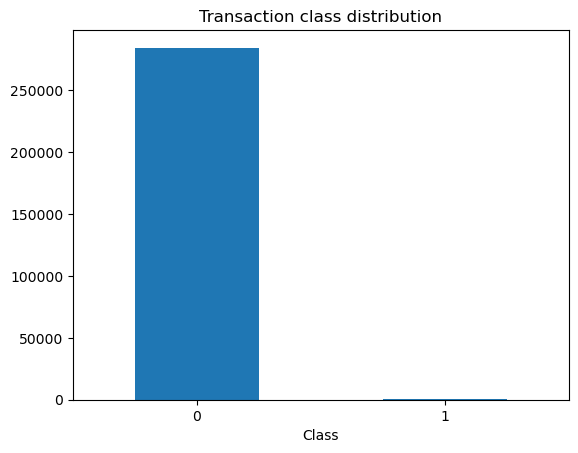

In [30]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), Num)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [31]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [32]:
frauds.shape

(492, 30)

In [33]:
normal.shape

(284315, 30)

In [35]:
frauds.Amount.describe()

count    492.000000
mean       0.135382
std        1.026242
min       -0.353229
25%       -0.349231
50%       -0.316247
75%        0.070128
max        8.146182
Name: Amount, dtype: float64

In [36]:
normal.Amount.describe()

count    284315.000000
mean         -0.000234
std           0.999942
min          -0.353229
25%          -0.330640
50%          -0.265271
75%          -0.045177
max         102.362243
Name: Amount, dtype: float64

In [6]:
df.drop(['Time'], axis=1, inplace=True)
df['Amount'] = StandardScaler().fit_transform(df[['Amount']])

In [7]:
X = df.drop('Class', axis=1).values
y = df['Class'].values

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


In [9]:
def add_noise(data, noise_factor=0.2):
    noise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape)
    return np.clip(data + noise, 0., 1.)

X_train_noisy = add_noise(X_train_res)


In [10]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Autoencoder architecture
input_dim = X_train_res.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(22, activation='relu')(input_layer)
encoded = Dense(15, activation='relu')(encoded)
encoded = Dense(10, activation='relu')(encoded)
decoded = Dense(15, activation='relu')(encoded)
decoded = Dense(22, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train autoencoder
autoencoder.fit(X_train_noisy, X_train_res, 
                epochs=20, 
                batch_size=256,
                shuffle=True, 
                validation_split=0.2, 
                verbose=1)


Epoch 1/20
1422/1422 [==============================] - 6s 3ms/step - loss: 10.2580 - val_loss: 25.1623
Epoch 2/20
1422/1422 [==============================] - 4s 3ms/step - loss: 10.1758 - val_loss: 25.1501
Epoch 3/20
1422/1422 [==============================] - 4s 3ms/step - loss: 10.1633 - val_loss: 25.1328
Epoch 4/20
1422/1422 [==============================] - 4s 3ms/step - loss: 10.1554 - val_loss: 25.1280
Epoch 5/20
1422/1422 [==============================] - 4s 3ms/step - loss: 10.1508 - val_loss: 25.1226
Epoch 6/20
1422/1422 [==============================] - 4s 3ms/step - loss: 10.1488 - val_loss: 25.1215
Epoch 7/20
1422/1422 [==============================] - 4s 3ms/step - loss: 10.1411 - val_loss: 25.0947
Epoch 8/20
1422/1422 [==============================] - 4s 3ms/step - loss: 10.1295 - val_loss: 25.0883
Epoch 9/20
1422/1422 [==============================] - 4s 3ms/step - loss: 10.1039 - val_loss: 25.0815
Epoch 10/20
1422/1422 [==============================] - 4s 3ms/

In [11]:
X_train_denoised = autoencoder.predict(X_train_res)
X_test_denoised = autoencoder.predict(X_test)


1781/1781 [==============================] - 2s 887us/step


In [12]:
# Classifier model
classifier_input = Input(shape=(input_dim,))
x = Dense(22, activation='relu')(classifier_input)
x = Dense(15, activation='relu')(x)
x = Dense(10, activation='relu')(x)
x = Dense(5, activation='relu')(x)
x = Dense(2, activation='softmax')(x)

classifier = Model(classifier_input, x)
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train classifier
classifier.fit(X_train_denoised, y_train_res, 
               epochs=20, 
               batch_size=256, 
               validation_split=0.2, 
               verbose=1)


Epoch 1/20
1422/1422 [==============================] - 5s 3ms/step - loss: 0.1912 - accuracy: 0.9332 - val_loss: 0.2263 - val_accuracy: 0.8977
Epoch 2/20
1422/1422 [==============================] - 4s 3ms/step - loss: 0.1248 - accuracy: 0.9514 - val_loss: 0.1799 - val_accuracy: 0.9031
Epoch 3/20
1422/1422 [==============================] - 4s 3ms/step - loss: 0.1185 - accuracy: 0.9523 - val_loss: 0.1643 - val_accuracy: 0.9049
Epoch 4/20
1422/1422 [==============================] - 4s 3ms/step - loss: 0.1127 - accuracy: 0.9535 - val_loss: 0.1674 - val_accuracy: 0.9278
Epoch 5/20
1422/1422 [==============================] - 4s 3ms/step - loss: 0.1081 - accuracy: 0.9561 - val_loss: 0.1352 - val_accuracy: 0.9475
Epoch 6/20
1422/1422 [==============================] - 4s 3ms/step - loss: 0.1050 - accuracy: 0.9577 - val_loss: 0.1659 - val_accuracy: 0.9187
Epoch 7/20
1422/1422 [==============================] - 4s 3ms/step - loss: 0.1018 - accuracy: 0.9593 - val_loss: 0.1420 - val_accuracy:

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score

# Predict and evaluate
y_pred_probs = classifier.predict(X_test_denoised)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


1781/1781 [==============================] - 2s 871us/step
Accuracy: 0.9701730978547102
Recall: 0.8775510204081632

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98     56864
           1       0.05      0.88      0.09        98

    accuracy                           0.97     56962
   macro avg       0.52      0.92      0.54     56962
weighted avg       1.00      0.97      0.98     56962



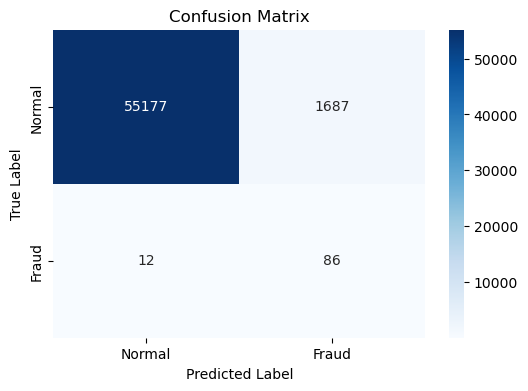

In [14]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming y_test = true labels, y_pred = predicted labels
cm = confusion_matrix(y_test, y_pred)

# Option 1: Using seaborn heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Fraud'], 
            yticklabels=['Normal', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Option 2: Using built-in display from sklearn (alternative)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Fraud'])
# disp.plot(cmap='Blues')
# plt.show()

In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Define Model 1 (same architecture as Model 2 for fairness)
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))
x = Dense(22, activation='relu')(input_layer)
x = Dense(15, activation='relu')(x)
x = Dense(10, activation='relu')(x)
x = Dense(5, activation='relu')(x)
x = Dense(2, activation='softmax')(x)

model1_classifier = Model(input_layer, x)
model1_classifier.compile(optimizer='adam', 
                          loss='sparse_categorical_crossentropy', 
                          metrics=['accuracy'])

# Train model on original imbalanced data (no SMOTE, no denoising)
model1_classifier.fit(X_train, y_train, 
                      epochs=20, batch_size=256, 
                      validation_split=0.2, 
                      shuffle=True)

Epoch 1/20
713/713 [==============================] - 3s 3ms/step - loss: 0.0889 - accuracy: 0.9741 - val_loss: 0.0040 - val_accuracy: 0.9994
Epoch 2/20
713/713 [==============================] - 2s 3ms/step - loss: 0.0036 - accuracy: 0.9994 - val_loss: 0.0034 - val_accuracy: 0.9994
Epoch 3/20
713/713 [==============================] - 2s 3ms/step - loss: 0.0031 - accuracy: 0.9994 - val_loss: 0.0033 - val_accuracy: 0.9994
Epoch 4/20
713/713 [==============================] - 2s 3ms/step - loss: 0.0029 - accuracy: 0.9994 - val_loss: 0.0030 - val_accuracy: 0.9994
Epoch 5/20
713/713 [==============================] - 2s 3ms/step - loss: 0.0028 - accuracy: 0.9994 - val_loss: 0.0030 - val_accuracy: 0.9994
Epoch 6/20
713/713 [==============================] - 2s 3ms/step - loss: 0.0026 - accuracy: 0.9994 - val_loss: 0.0029 - val_accuracy: 0.9995
Epoch 7/20
713/713 [==============================] - 2s 3ms/step - loss: 0.0025 - accuracy: 0.9994 - val_loss: 0.0032 - val_accuracy: 0.9992
Epoch 

In [21]:
# Predict probabilities from Model 1
y_pred_probs_model1 = model1_classifier.predict(X_test)  # shape: (n_samples, 2)
y_scores_model1 = y_pred_probs_model1[:, 1]  # get fraud class probability

# Compute ROC curve and AUC
fpr1, tpr1, _ = roc_curve(y_test, y_scores_model1)
auc1 =auc(fpr1,tpr1)

1781/1781 [==============================] - 2s 851us/step


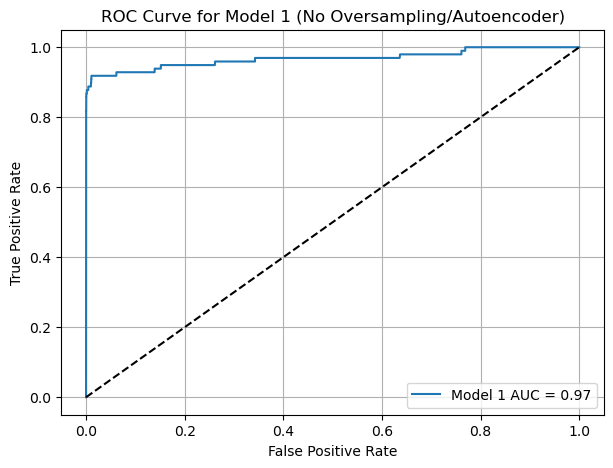

In [25]:


# Plot
plt.figure(figsize=(7,5))
plt.plot(fpr1, tpr1, label=f'Model 1 AUC = {auc1:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Model 1 (No Oversampling/Autoencoder)')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
y_pred_probs_model2 = classifier.predict(X_test_denoised)
y_scores_model2 = y_pred_probs_model2[:, 1]

fpr2, tpr2, _ = roc_curve(y_test, y_scores_model2)
auc2 = auc(fpr2, tpr2)

1781/1781 [==============================] - 2s 883us/step


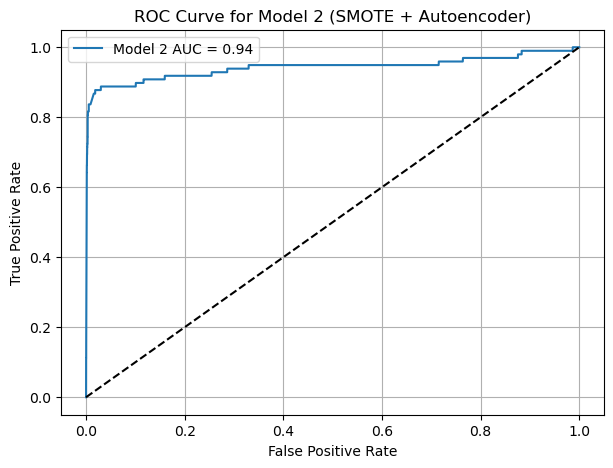

In [26]:
plt.figure(figsize=(7,5))
plt.plot(fpr2, tpr2, label=f'Model 2 AUC = {auc2:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Model 2 (SMOTE + Autoencoder)')
plt.legend()
plt.grid(True)
plt.show()

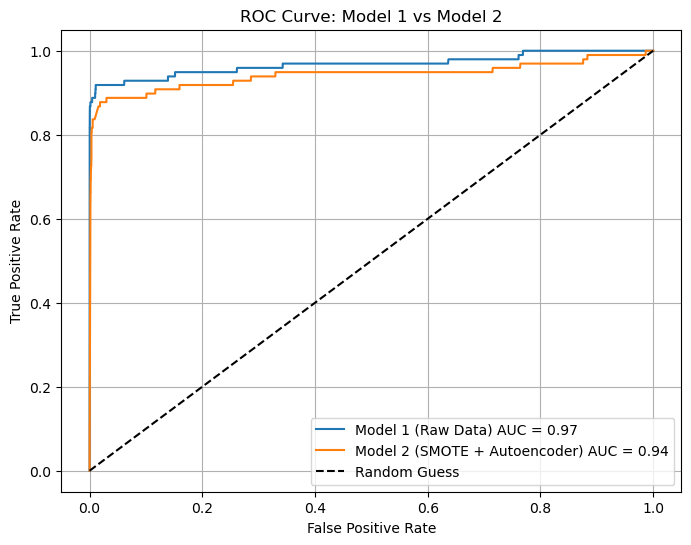

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(fpr1, tpr1, label=f'Model 1 (Raw Data) AUC = {auc1:.2f}')
plt.plot(fpr2, tpr2, label=f'Model 2 (SMOTE + Autoencoder) AUC = {auc2:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Model 1 vs Model 2')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [40]:
# Save your trained models after training
autoencoder.save("autoencoder.h5")
classifier.save("classifier.h5")
